In [1]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

### Prepare the data

In [3]:
df = pd.read_csv(r"C:\Users\Dickson\Titanic\train.csv")

In [19]:
def add_features(df):
    df['LogFare'] = np.log(df['Fare'] + 1)
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==1
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ',expand=True)[1].str.split(',', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr", Miss="Miss", Mrs="Mrs", Master="Master")).value_counts(dropna=False)
    
add_features(df)    

In [20]:
splits = RandomSplitter(seed=42)(df)

In [24]:
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=["Sex", "Pclass","Embarked","Deck","Title"],
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    y_names="Survived", y_block = CategoryBlock(),
).dataloaders()    

### Train the model

In [25]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])

C:\Users\Dickson\anaconda3\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_k

SuggestedLRs(slide=0.0831763744354248, valley=0.02290867641568184)

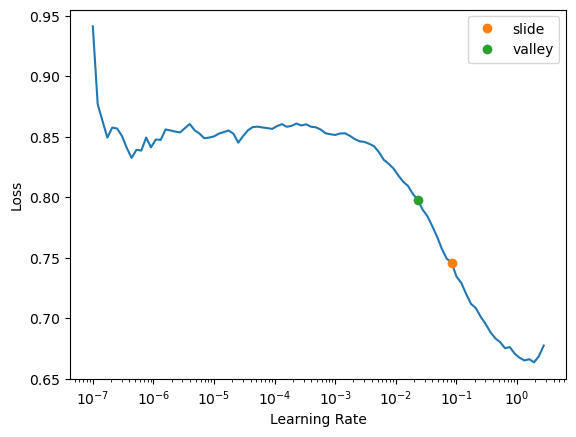

In [28]:
learn.lr_find(suggest_funcs=(slide, valley))

In [29]:
learn.fit(16, lr=0.03)

epoch,train_loss,valid_loss,accuracy,time
0,0.558287,0.611685,0.606742,00:00
1,0.534581,0.509735,0.719101,00:00
2,0.494151,0.427672,0.814607,00:00
3,0.456231,0.456720,0.786517,00:00
4,0.436107,0.429673,0.797753,00:00
5,0.442829,0.417619,0.808989,00:00
6,0.433779,0.411616,0.820225,00:00
7,0.424946,0.458794,0.814607,00:00
8,0.428162,0.437440,0.803371,00:00
9,0.424641,0.409891,0.820225,00:00


### Ensembling

In [33]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])
    with learn.no_bar(),learn.no_logging(): learn.fit(16, lr=0.03)
    return learn.get_preds(dl=tst_dl)[0]

In [35]:
learns = [ensemble() for _ in range(5)]

NameError: name 'tst_dl' is not defined

In [ ]:
ens_preds = torch.stack(learns).mean(0)